In [1]:
# 🧼 DENOISING AUTOENCODER (DAE) IN PYTORCH
# =====================================================
# GOAL: Train a CNN autoencoder to remove Gaussian noise from MNIST images.
# Learn a compressed latent representation and reconstruct the input image.
# =====================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

In [2]:
# Apply basic transform to convert images to tensors in [0, 1]
transform = transforms.ToTensor()

# Download the MNIST training data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

In [3]:
def add_noise(inputs, noise_level=0.5):
    noise = torch.randn_like(inputs) * noise_level
    noised = inputs + noise
    return torch.clamp(noised, 0., 1.)  # Keep pixel values in [0, 1]

In [4]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # ENCODER: Conv → ReLU → Pool
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),   # (1,28,28) → (8,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2),                             # (8,28,28) → (8,14,14)
            nn.Conv2d(8, 16, kernel_size=3, padding=1),  # (8,14,14) → (16,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2)                              # (16,14,14) → (16,7,7)
        )

        # DECODER: Upsample → Conv → ReLU → Final Conv
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),  # (16,7,7) → (8,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),   # (8,14,14) → (1,28,28)
            nn.Sigmoid()  # Keep output in [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = DenoisingAutoencoder()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Minimize mean squared difference between clean and output

In [6]:
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        noised = add_noise(images)            # Add noise to inputs
        outputs = model(noised)               # Reconstruct clean image
        loss = loss_fn(outputs, images)       # Compare to original clean image

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss = {avg_loss:.4f}")

Epoch 1, Loss = 0.0613
Epoch 2, Loss = 0.0248
Epoch 3, Loss = 0.0214
Epoch 4, Loss = 0.0201
Epoch 5, Loss = 0.0194


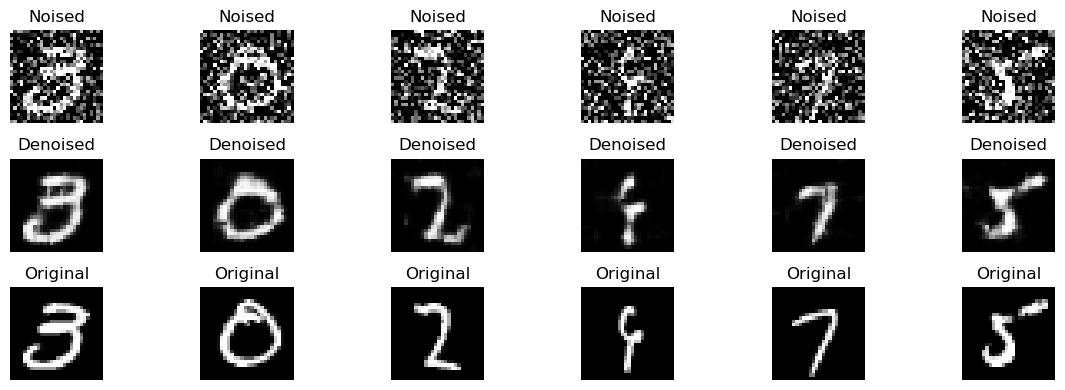

In [7]:
model.eval()
images, _ = next(iter(train_loader))
noised = add_noise(images)

with torch.no_grad():
    denoised = model(noised)

# Plot side-by-side comparison
n = 6
plt.figure(figsize=(12, 4))
for i in range(n):
    # Noised
    plt.subplot(3, n, i + 1)
    plt.imshow(noised[i][0], cmap='gray')
    plt.title("Noised")
    plt.axis("off")

    # Denoised
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised[i][0], cmap='gray')
    plt.title("Denoised")
    plt.axis("off")

    # Ground truth
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(images[i][0], cmap='gray')
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()